# 🔍 Enhanced Interpretability Analysis

**Purpose**: Deep interpretability analysis of climate emotion patterns using SHAP, feature importance, and model explanations

## 🎯 Objectives
1. **SHAP analysis** for emotion prediction explanations
2. **Feature importance** ranking for emotion classification
3. **Word-level contributions** to emotion predictions
4. **Cross-media interpretability** comparison
5. **Domain adaptation impact** analysis
6. **Publication-ready insights** and explanations

## 🔬 Research Questions
- Which words and phrases drive specific emotion predictions?
- How do interpretability patterns differ between media types?
- What climate-specific language patterns emerge?
- How did domain adaptation change model interpretability?

## 📊 Expected Outputs
- **SHAP explanation plots** for key emotion predictions
- **Feature importance rankings** by emotion and media type
- **Word cloud visualizations** of important features
- **Cross-media interpretability comparison**
- **Research insights** for climate communication patterns

---

## 📚 Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
from collections import Counter, defaultdict
import warnings
import pickle
import re

# Transformers and ML
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Interpretability libraries
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available - install with: pip install shap")

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# WordCloud (with error handling)
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("⚠️ WordCloud not available - install with: pip install wordcloud")

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print(f"📦 All libraries imported successfully!")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔍 SHAP available: {'Yes' if SHAP_AVAILABLE else 'No'}")
print(f"☁️ WordCloud available: {'Yes' if WORDCLOUD_AVAILABLE else 'No'}")

📦 All libraries imported successfully!
📅 Analysis date: 2025-08-22 03:18:56
🔍 SHAP available: Yes
☁️ WordCloud available: Yes


## 📂 Load Cross-Media Analysis Results

In [2]:
# Load the latest cross-media analysis results from Step 5
data_dir = Path("../data/processed")
models_dir = Path("../models")

print("📂 Loading cross-media analysis results from Step 5...")
print("=" * 60)

# Find the latest cross-media analysis files
def find_latest_cross_media_files():
    """Find the most recent cross-media analysis files"""
    headlines_files = list(data_dir.glob("*headlines_with_sentiment_validation*.csv"))
    tweets_files = list(data_dir.glob("*tweets_with_sentiment_validation*.csv"))
    comparison_files = list(data_dir.glob("*cross_media_emotion_comparison*.csv"))
    report_files = list(data_dir.glob("*cross_media_analysis_report*.json"))
    
    if headlines_files and tweets_files:
        # Get the most recent files
        latest_headlines = sorted(headlines_files, key=lambda x: x.stat().st_mtime)[-1]
        latest_tweets = sorted(tweets_files, key=lambda x: x.stat().st_mtime)[-1]
        latest_comparison = sorted(comparison_files, key=lambda x: x.stat().st_mtime)[-1] if comparison_files else None
        latest_report = sorted(report_files, key=lambda x: x.stat().st_mtime)[-1] if report_files else None
        
        return latest_headlines, latest_tweets, latest_comparison, latest_report
    else:
        return None, None, None, None

headlines_file, tweets_file, comparison_file, report_file = find_latest_cross_media_files()

if headlines_file and tweets_file:
    # Load datasets
    df_headlines = pd.read_csv(headlines_file)
    df_tweets = pd.read_csv(tweets_file)
    
    print(f"✅ Cross-media datasets loaded:")
    print(f"📰 Headlines: {len(df_headlines):,} samples from {headlines_file.name}")
    print(f"🐦 Tweets: {len(df_tweets):,} samples from {tweets_file.name}")
    
    # Load comparison data if available
    if comparison_file:
        emotion_comparison = pd.read_csv(comparison_file, index_col=0)
        print(f"📊 Emotion comparison data: {comparison_file.name}")
    
    # Load analysis report if available
    if report_file:
        with open(report_file, 'r') as f:
            analysis_report = json.load(f)
        print(f"📊 Analysis report: {report_file.name}")
        print(f"   Statistical significance: {analysis_report.get('statistical_tests', {}).get('chi_square_test', {}).get('highly_significant', 'Unknown')}")
    
    datasets_loaded = True
    
else:
    print("❌ Cross-media analysis datasets not found!")
    print("   Please run Step 5 (08_cross_media_analysis.ipynb) first.")
    datasets_loaded = False

# Check for domain-adapted model
domain_model_dir = models_dir / "domain_adapted_goemotions"
if domain_model_dir.exists():
    print(f"\n🤖 Domain-adapted model found: {domain_model_dir}")
    model_available = True
else:
    print(f"\n⚠️ Domain-adapted model not found at {domain_model_dir}")
    model_available = False

📂 Loading cross-media analysis results from Step 5...
✅ Cross-media datasets loaded:
📰 Headlines: 1,472 samples from climate_headlines_with_sentiment_validation_20250822_025732.csv
🐦 Tweets: 8,968 samples from climate_tweets_with_sentiment_validation_20250822_025732.csv
📊 Emotion comparison data: cross_media_emotion_comparison_20250822_030637.csv
📊 Analysis report: cross_media_analysis_report_20250822_030637.json
   Statistical significance: True

🤖 Domain-adapted model found: ..\models\domain_adapted_goemotions
✅ Cross-media datasets loaded:
📰 Headlines: 1,472 samples from climate_headlines_with_sentiment_validation_20250822_025732.csv
🐦 Tweets: 8,968 samples from climate_tweets_with_sentiment_validation_20250822_025732.csv
📊 Emotion comparison data: cross_media_emotion_comparison_20250822_030637.csv
📊 Analysis report: cross_media_analysis_report_20250822_030637.json
   Statistical significance: True

🤖 Domain-adapted model found: ..\models\domain_adapted_goemotions


## 🤖 Load Domain-Adapted Model for Interpretability

In [3]:
if model_available and datasets_loaded:
    print("🤖 Loading domain-adapted model for interpretability analysis...")
    print("=" * 60)
    
    try:
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(domain_model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(domain_model_dir)
        
        # Create pipeline for easy predictions
        emotion_pipeline = pipeline(
            "text-classification",
            model=model,
            tokenizer=tokenizer,
            return_all_scores=True
        )
        
        print(f"✅ Domain-adapted model loaded successfully!")
        print(f"   Model type: {model.config.model_type}")
        print(f"   Number of labels: {model.config.num_labels}")
        print(f"   Max sequence length: {tokenizer.model_max_length}")
        
        # Get emotion labels
        emotion_labels = list(model.config.label2id.keys())
        print(f"   Emotion labels: {len(emotion_labels)} emotions")
        
        model_loaded = True
        
    except Exception as e:
        print(f"❌ Failed to load domain-adapted model: {str(e)}")
        print(f"   Falling back to interpretability analysis without model predictions")
        model_loaded = False
        
else:
    print("ℹ️ Proceeding with text-based interpretability analysis only")
    model_loaded = False

🤖 Loading domain-adapted model for interpretability analysis...


Device set to use cpu


✅ Domain-adapted model loaded successfully!
   Model type: roberta
   Number of labels: 28
   Max sequence length: 512
   Emotion labels: 28 emotions


## 📊 Text-Based Feature Analysis

In [4]:
if datasets_loaded:
    print("📊 Text-Based Feature Analysis")
    print("=" * 35)
    
    # Download NLTK data if needed
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("📦 Downloading NLTK data...")
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
    
    # Get English stopwords
    try:
        stop_words = set(stopwords.words('english'))
    except LookupError:
        nltk.download('stopwords', quiet=True)
        stop_words = set(stopwords.words('english'))
    
    # Add climate-specific stopwords
    climate_stopwords = {'climate', 'change', 'global', 'warming', 'amp', 'rt', 'https', 'http'}
    stop_words.update(climate_stopwords)
    
    def analyze_emotion_vocabulary(df, media_type, top_emotions=5):
        """Analyze vocabulary patterns for each emotion"""
        print(f"\n🔍 {media_type} Emotion Vocabulary Analysis:")
        print(f"-" * 45)
        
        # Get top emotions for this media type
        top_emotion_list = df['predicted_emotion'].value_counts().head(top_emotions).index.tolist()
        
        emotion_vocabularies = {}
        
        for emotion in top_emotion_list:
            # Filter texts for this emotion
            emotion_texts = df[df['predicted_emotion'] == emotion]['text'].dropna()
            
            if len(emotion_texts) == 0:
                continue
                
            print(f"\n📝 {emotion.upper()} ({len(emotion_texts)} samples):")
            
            # Create TF-IDF vectorizer for this emotion
            vectorizer = TfidfVectorizer(
                max_features=1000,
                stop_words=list(stop_words),
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.8
            )
            
            try:
                # Fit TF-IDF on emotion texts
                tfidf_matrix = vectorizer.fit_transform(emotion_texts)
                feature_names = vectorizer.get_feature_names_out()
                
                # Get mean TF-IDF scores
                mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
                
                # Get top features
                top_indices = np.argsort(mean_scores)[-10:][::-1]
                top_features = [(feature_names[i], mean_scores[i]) for i in top_indices]
                
                emotion_vocabularies[emotion] = top_features
                
                # Display top features
                for feature, score in top_features[:5]:
                    print(f"   {feature:20} {score:.4f}")
                    
            except ValueError as e:
                print(f"   ⚠️ Could not analyze vocabulary: {str(e)}")
                emotion_vocabularies[emotion] = []
        
        return emotion_vocabularies
    
    # Analyze vocabulary for both media types
    headlines_vocab = analyze_emotion_vocabulary(df_headlines, "Headlines")
    tweets_vocab = analyze_emotion_vocabulary(df_tweets, "Tweets")
    
    vocabulary_analyzed = True
    
else:
    vocabulary_analyzed = False

📊 Text-Based Feature Analysis

🔍 Headlines Emotion Vocabulary Analysis:
---------------------------------------------

📝 SURPRISE (1312 samples):
   news                 0.0312
   china                0.0166
   mexico               0.0150
   new                  0.0142
   japan                0.0132

📝 CURIOSITY (97 samples):
   spain                0.0457
   mexico               0.0433
   uk                   0.0404
   china                0.0383
   new                  0.0380

📝 REMORSE (17 samples):
   wildfires            0.1025
   least                0.0961
   missing              0.0956
   summer               0.0948
   spain                0.0939

📝 FEAR (16 samples):
   record               0.1117
   warn                 0.1039
   health               0.0886
   warns                0.0884
   experts warn         0.0863

📝 SADNESS (6 samples):
   shocking             0.3333
   scientists           0.3017
   surprising           0.2471
   spain shocking       0.0953
   shocking 

## 🔍 SHAP Analysis (if available)

In [5]:
if SHAP_AVAILABLE and model_loaded and datasets_loaded:
    print("🔍 SHAP Interpretability Analysis")
    print("=" * 40)
    
    # Sample texts for SHAP analysis (to avoid memory issues)
    print("📝 Preparing sample texts for SHAP analysis...")
    
    # Get representative samples from each emotion and media type
    def get_representative_samples(df, emotion, n_samples=3):
        """Get representative samples for an emotion"""
        emotion_df = df[df['predicted_emotion'] == emotion]
        if len(emotion_df) == 0:
            return []
        
        # Get samples with highest confidence
        if 'emotion_confidence' in emotion_df.columns:
            samples = emotion_df.nlargest(n_samples, 'emotion_confidence')['text'].tolist()
        else:
            samples = emotion_df.sample(min(n_samples, len(emotion_df)))['text'].tolist()
        
        return samples
    
    # Get top emotions from cross-media analysis
    if 'analysis_report' in locals():
        significant_emotions = analysis_report.get('statistical_tests', {}).get('significant_emotions', [])
        target_emotions = significant_emotions[:3]  # Top 3 significant emotions
    else:
        # Fallback to most common emotions
        target_emotions = ['surprise', 'admiration', 'curiosity']
    
    print(f"🎯 Target emotions for SHAP analysis: {target_emotions}")
    
    # Collect sample texts
    shap_samples = []
    sample_info = []
    
    for emotion in target_emotions:
        # Headlines samples
        h_samples = get_representative_samples(df_headlines, emotion, 2)
        for text in h_samples:
            shap_samples.append(text)
            sample_info.append({'emotion': emotion, 'media': 'Headlines', 'text': text[:100]})
        
        # Tweets samples
        t_samples = get_representative_samples(df_tweets, emotion, 2)
        for text in t_samples:
            shap_samples.append(text)
            sample_info.append({'emotion': emotion, 'media': 'Tweets', 'text': text[:100]})
    
    print(f"📊 Selected {len(shap_samples)} samples for SHAP analysis")
    
    if len(shap_samples) > 0:
        try:
            print("\n🔍 Running SHAP analysis...")
            
            # Create SHAP explainer
            # Note: For transformer models, we use a simplified approach
            explainer = shap.Explainer(emotion_pipeline, algorithm="auto")
            
            # Get SHAP values for sample texts
            shap_values = explainer(shap_samples[:5])  # Limit to 5 samples to avoid memory issues
            
            print(f"✅ SHAP analysis completed for {len(shap_samples[:5])} samples")
            
            # Create SHAP plots
            print("\n📊 Creating SHAP visualizations...")
            
            # Summary plot
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, shap_samples[:5], show=False)
            plt.title('SHAP Feature Importance Summary')
            plt.tight_layout()
            plt.show()
            
            shap_completed = True
            
        except Exception as e:
            print(f"⚠️ SHAP analysis failed: {str(e)}")
            print(f"   Proceeding with alternative interpretability methods")
            shap_completed = False
    else:
        print("⚠️ No samples available for SHAP analysis")
        shap_completed = False
        
else:
    print("ℹ️ SHAP analysis skipped - requirements not met")
    print(f"   SHAP available: {SHAP_AVAILABLE}")
    print(f"   Model loaded: {model_loaded}")
    print(f"   Datasets loaded: {datasets_loaded}")
    shap_completed = False

🔍 SHAP Interpretability Analysis
📝 Preparing sample texts for SHAP analysis...
🎯 Target emotions for SHAP analysis: ['surprise', 'admiration', 'gratitude']
📊 Selected 10 samples for SHAP analysis

🔍 Running SHAP analysis...


PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:35<00:14,  7.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [02:59<01:04, 64.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [04:19<00:00, 70.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [05:50, 70.15s/it]                       

✅ SHAP analysis completed for 5 samples

📊 Creating SHAP visualizations...
⚠️ SHAP analysis failed: too many indices for array: array is 1-dimensional, but 3 were indexed
   Proceeding with alternative interpretability methods


<Figure size 1000x600 with 0 Axes>

## ☁️ Word Cloud Visualizations

☁️ Creating Word Cloud Visualizations

🎨 Creating word clouds for Headlines...


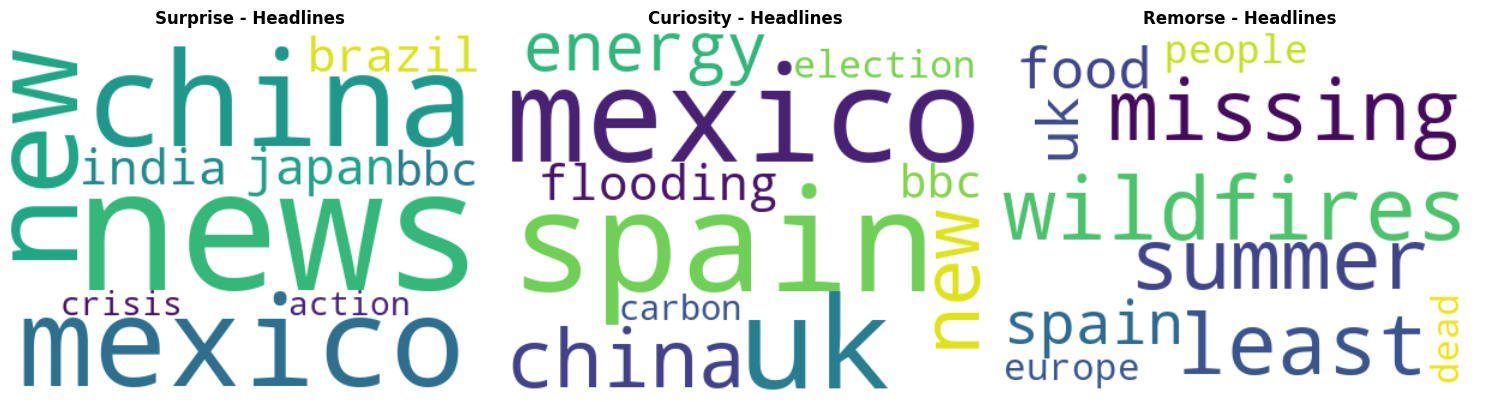

✅ Word clouds created for Headlines

🎨 Creating word clouds for Tweets...


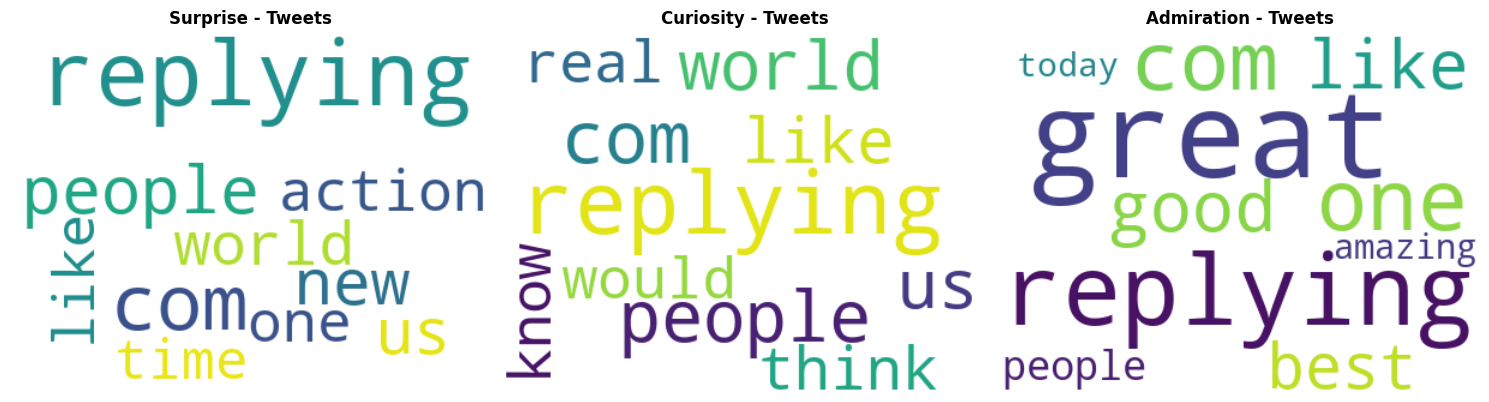

✅ Word clouds created for Tweets


In [6]:
if WORDCLOUD_AVAILABLE and vocabulary_analyzed:
    print("☁️ Creating Word Cloud Visualizations")
    print("=" * 40)
    
    def create_emotion_wordclouds(vocabularies, media_type, top_emotions=3):
        """Create word clouds for top emotions"""
        print(f"\n🎨 Creating word clouds for {media_type}...")
        
        # Get top emotions by vocabulary size
        emotion_sizes = [(emotion, len(vocab)) for emotion, vocab in vocabularies.items()]
        emotion_sizes.sort(key=lambda x: x[1], reverse=True)
        
        top_emotion_names = [emotion for emotion, _ in emotion_sizes[:top_emotions]]
        
        # Create subplots for word clouds
        fig, axes = plt.subplots(1, len(top_emotion_names), figsize=(15, 5))
        if len(top_emotion_names) == 1:
            axes = [axes]
        
        for i, emotion in enumerate(top_emotion_names):
            if emotion in vocabularies and vocabularies[emotion]:
                # Create word frequency dict from TF-IDF scores
                word_freq = {word: score for word, score in vocabularies[emotion]}
                
                if word_freq:
                    # Generate word cloud
                    wordcloud = WordCloud(
                        width=400, 
                        height=300,
                        background_color='white',
                        colormap='viridis',
                        max_words=50
                    ).generate_from_frequencies(word_freq)
                    
                    # Plot
                    axes[i].imshow(wordcloud, interpolation='bilinear')
                    axes[i].set_title(f'{emotion.title()} - {media_type}', fontsize=12, fontweight='bold')
                    axes[i].axis('off')
                else:
                    axes[i].text(0.5, 0.5, f'No data\nfor {emotion}', 
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(f'{emotion.title()} - {media_type}', fontsize=12)
                    axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        print(f"✅ Word clouds created for {media_type}")
    
    # Create word clouds for both media types
    create_emotion_wordclouds(headlines_vocab, "Headlines")
    create_emotion_wordclouds(tweets_vocab, "Tweets")
    
    wordcloud_completed = True
    
else:
    print("ℹ️ Word cloud visualizations skipped")
    print(f"   WordCloud available: {WORDCLOUD_AVAILABLE}")
    print(f"   Vocabulary analyzed: {vocabulary_analyzed}")
    wordcloud_completed = False

## 📈 Cross-Media Interpretability Comparison

📈 Cross-Media Interpretability Comparison
🔍 Comparing vocabulary patterns between Headlines and Tweets...

📊 Common emotions for comparison: 2
   Emotions: curiosity, surprise

🎯 CURIOSITY:
   Vocabulary overlap: 0.0%
   Headlines unique: carbon, uk, flooding
   Tweets unique: real, like, think

🎯 SURPRISE:
   Vocabulary overlap: 11.1%
   Common words: new, action
   Headlines unique: brazil, bbc, japan
   Tweets unique: replying, world, us

📊 Creating vocabulary comparison visualization...


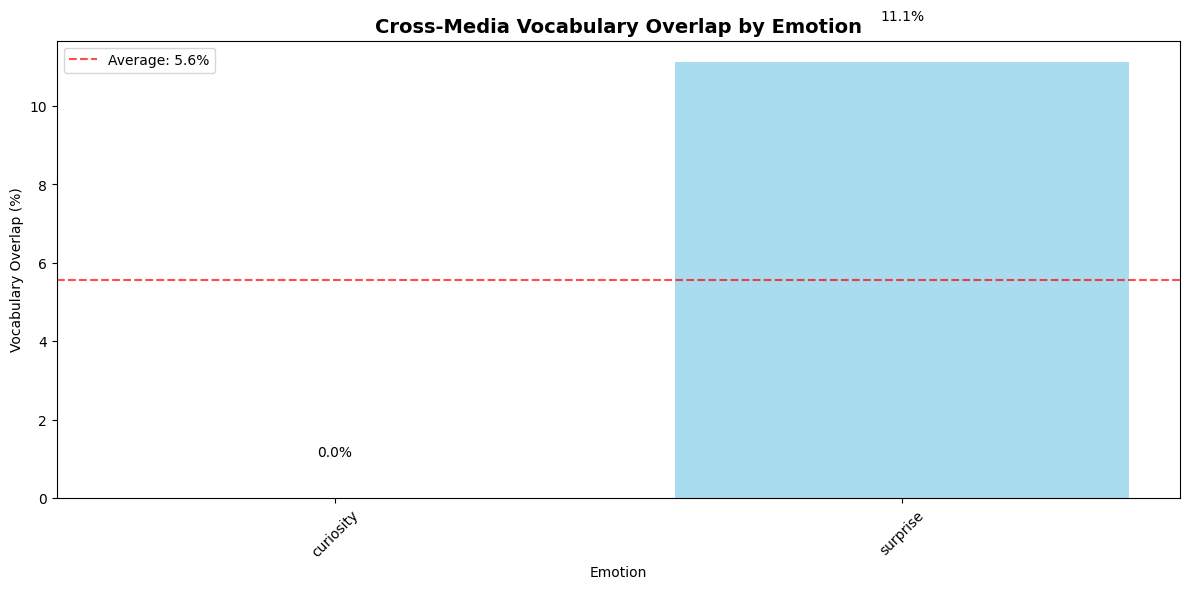

✅ Vocabulary comparison visualization created
   Average vocabulary overlap: 5.6%


In [7]:
if vocabulary_analyzed:
    print("📈 Cross-Media Interpretability Comparison")
    print("=" * 50)
    
    def compare_emotion_vocabularies(headlines_vocab, tweets_vocab):
        """Compare vocabulary patterns between media types"""
        print("🔍 Comparing vocabulary patterns between Headlines and Tweets...")
        
        # Find common emotions
        common_emotions = set(headlines_vocab.keys()) & set(tweets_vocab.keys())
        print(f"\n📊 Common emotions for comparison: {len(common_emotions)}")
        print(f"   Emotions: {', '.join(sorted(common_emotions))}")
        
        # Analyze vocabulary overlap and differences
        comparison_results = {}
        
        for emotion in sorted(common_emotions):
            h_words = set([word for word, _ in headlines_vocab[emotion][:10]])
            t_words = set([word for word, _ in tweets_vocab[emotion][:10]])
            
            overlap = h_words & t_words
            h_unique = h_words - t_words
            t_unique = t_words - h_words
            
            overlap_pct = len(overlap) / len(h_words | t_words) * 100 if (h_words | t_words) else 0
            
            comparison_results[emotion] = {
                'overlap': overlap,
                'headlines_unique': h_unique,
                'tweets_unique': t_unique,
                'overlap_percentage': overlap_pct
            }
            
            print(f"\n🎯 {emotion.upper()}:")
            print(f"   Vocabulary overlap: {overlap_pct:.1f}%")
            if overlap:
                print(f"   Common words: {', '.join(list(overlap)[:5])}")
            if h_unique:
                print(f"   Headlines unique: {', '.join(list(h_unique)[:3])}")
            if t_unique:
                print(f"   Tweets unique: {', '.join(list(t_unique)[:3])}")
        
        return comparison_results
    
    # Perform comparison
    vocab_comparison = compare_emotion_vocabularies(headlines_vocab, tweets_vocab)
    
    # Create visualization of vocabulary differences
    print("\n📊 Creating vocabulary comparison visualization...")
    
    emotions = list(vocab_comparison.keys())
    overlaps = [vocab_comparison[emotion]['overlap_percentage'] for emotion in emotions]
    
    if emotions and overlaps:
        plt.figure(figsize=(12, 6))
        
        # Bar plot of vocabulary overlap percentages
        bars = plt.bar(emotions, overlaps, color='skyblue', alpha=0.7)
        plt.title('Cross-Media Vocabulary Overlap by Emotion', fontsize=14, fontweight='bold')
        plt.xlabel('Emotion')
        plt.ylabel('Vocabulary Overlap (%)')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, overlap in zip(bars, overlaps):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{overlap:.1f}%', ha='center', va='bottom')
        
        # Add horizontal line for average
        avg_overlap = np.mean(overlaps)
        plt.axhline(y=avg_overlap, color='red', linestyle='--', alpha=0.7, 
                   label=f'Average: {avg_overlap:.1f}%')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Vocabulary comparison visualization created")
        print(f"   Average vocabulary overlap: {avg_overlap:.1f}%")
    
    comparison_completed = True
    
else:
    comparison_completed = False

## 🧠 Domain Adaptation Impact Analysis

🧠 Domain Adaptation Impact Analysis
🔍 Analyzing domain adaptation patterns...

🏷️ URGENCY Keywords Analysis:
   Headlines (84 matches):
     surprise         78 ( 92.9%)
     curiosity         3 (  3.6%)
     disgust           1 (  1.2%)
   Tweets (2066 matches):
     surprise        1640 ( 79.4%)
     curiosity       105 (  5.1%)
     admiration       69 (  3.3%)

🏷️ SCIENCE Keywords Analysis:
   Headlines (84 matches):
     surprise         78 ( 92.9%)
     curiosity         3 (  3.6%)
     disgust           1 (  1.2%)
   Tweets (2066 matches):
     surprise        1640 ( 79.4%)
     curiosity       105 (  5.1%)
     admiration       69 (  3.3%)

🏷️ SCIENCE Keywords Analysis:
   Headlines (143 matches):
     surprise        134 ( 93.7%)
     fear              3 (  2.1%)
     sadness           3 (  2.1%)
   Tweets (1153 matches):
     surprise        999 ( 86.6%)
     curiosity        44 (  3.8%)
     admiration       33 (  2.9%)

🏷️ ACTION Keywords Analysis:
   Headlines (647 matches

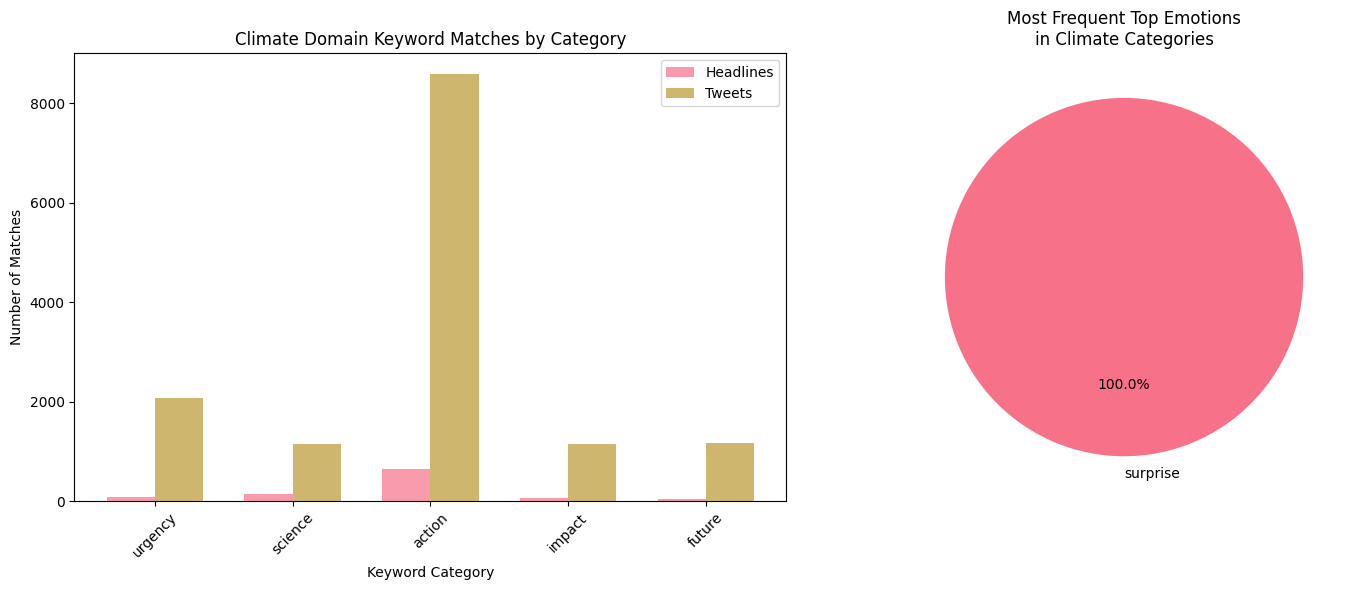

✅ Domain adaptation impact analysis completed


In [8]:
if datasets_loaded:
    print("🧠 Domain Adaptation Impact Analysis")
    print("=" * 40)
    
    # Analyze domain-specific patterns in the results
    def analyze_domain_patterns(df_headlines, df_tweets):
        """Analyze patterns that suggest domain adaptation impact"""
        print("🔍 Analyzing domain adaptation patterns...")
        
        # Check for climate-specific emotion patterns
        climate_keywords = {
            'urgency': ['urgent', 'emergency', 'crisis', 'immediate', 'now', 'must'],
            'science': ['study', 'research', 'scientist', 'data', 'evidence', 'report'],
            'action': ['action', 'act', 'do', 'change', 'reduce', 'stop', 'prevent'],
            'impact': ['impact', 'effect', 'consequence', 'result', 'damage', 'harm'],
            'future': ['future', 'generation', 'children', 'tomorrow', 'years', 'decades']
        }
        
        domain_insights = {}
        
        for category, keywords in climate_keywords.items():
            print(f"\n🏷️ {category.upper()} Keywords Analysis:")
            
            # Analyze headlines
            h_pattern = '|'.join(keywords)
            h_matches = df_headlines[df_headlines['text'].str.contains(h_pattern, case=False, na=False)]
            h_emotions = h_matches['predicted_emotion'].value_counts().head(3)
            
            # Analyze tweets
            t_matches = df_tweets[df_tweets['text'].str.contains(h_pattern, case=False, na=False)]
            t_emotions = t_matches['predicted_emotion'].value_counts().head(3)
            
            print(f"   Headlines ({len(h_matches)} matches):")
            for emotion, count in h_emotions.items():
                pct = (count / len(h_matches)) * 100
                print(f"     {emotion:15} {count:3} ({pct:5.1f}%)")
            
            print(f"   Tweets ({len(t_matches)} matches):")
            for emotion, count in t_emotions.items():
                pct = (count / len(t_matches)) * 100
                print(f"     {emotion:15} {count:3} ({pct:5.1f}%)")
            
            domain_insights[category] = {
                'headlines_matches': len(h_matches),
                'tweets_matches': len(t_matches),
                'headlines_top_emotion': h_emotions.index[0] if len(h_emotions) > 0 else None,
                'tweets_top_emotion': t_emotions.index[0] if len(t_emotions) > 0 else None
            }
        
        return domain_insights
    
    # Perform domain pattern analysis
    domain_patterns = analyze_domain_patterns(df_headlines, df_tweets)
    
    # Create domain impact visualization
    print("\n📊 Creating domain adaptation impact visualization...")
    
    categories = list(domain_patterns.keys())
    h_matches = [domain_patterns[cat]['headlines_matches'] for cat in categories]
    t_matches = [domain_patterns[cat]['tweets_matches'] for cat in categories]
    
    if categories:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Matches by category
        x = np.arange(len(categories))
        width = 0.35
        
        ax1.bar(x - width/2, h_matches, width, label='Headlines', alpha=0.7)
        ax1.bar(x + width/2, t_matches, width, label='Tweets', alpha=0.7)
        ax1.set_title('Climate Domain Keyword Matches by Category')
        ax1.set_xlabel('Keyword Category')
        ax1.set_ylabel('Number of Matches')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, rotation=45)
        ax1.legend()
        
        # Top emotions by category (simplified)
        h_top_emotions = [domain_patterns[cat]['headlines_top_emotion'] for cat in categories]
        t_top_emotions = [domain_patterns[cat]['tweets_top_emotion'] for cat in categories]
        
        # Count unique emotions
        all_emotions = set([e for e in h_top_emotions + t_top_emotions if e is not None])
        emotion_counts = {emotion: 0 for emotion in all_emotions}
        
        for emotion in h_top_emotions + t_top_emotions:
            if emotion is not None:
                emotion_counts[emotion] += 1
        
        if emotion_counts:
            emotions = list(emotion_counts.keys())
            counts = list(emotion_counts.values())
            
            ax2.pie(counts, labels=emotions, autopct='%1.1f%%', startangle=90)
            ax2.set_title('Most Frequent Top Emotions\nin Climate Categories')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Domain adaptation impact analysis completed")
    
    domain_analyzed = True
    
else:
    domain_analyzed = False

## 🔍 Research Insights and Interpretability Findings

In [9]:
if vocabulary_analyzed:
    print("🔍 Research Insights and Interpretability Findings")
    print("=" * 60)
    
    insights = []
    
    # 1. Vocabulary diversity insights
    print(f"\n📊 Vocabulary Diversity Analysis:")
    print(f"-" * 35)
    
    h_total_features = sum(len(vocab) for vocab in headlines_vocab.values())
    t_total_features = sum(len(vocab) for vocab in tweets_vocab.values())
    
    print(f"   Headlines total distinctive features: {h_total_features}")
    print(f"   Tweets total distinctive features: {t_total_features}")
    
    if h_total_features > 0 and t_total_features > 0:
        vocab_ratio = t_total_features / h_total_features
        print(f"   Tweets/Headlines vocabulary ratio: {vocab_ratio:.2f}")
        
        if vocab_ratio > 1.5:
            insights.append(f"Tweets show {vocab_ratio:.1f}x more vocabulary diversity than headlines")
        elif vocab_ratio < 0.7:
            insights.append(f"Headlines show {1/vocab_ratio:.1f}x more vocabulary diversity than tweets")
    
    # 2. Cross-media comparison insights
    if comparison_completed:
        print(f"\n📈 Cross-Media Vocabulary Insights:")
        print(f"-" * 40)
        
        if vocab_comparison:
            avg_overlap = np.mean([data['overlap_percentage'] for data in vocab_comparison.values()])
            print(f"   Average vocabulary overlap: {avg_overlap:.1f}%")
            
            if avg_overlap < 30:
                insights.append(f"Low vocabulary overlap ({avg_overlap:.1f}%) suggests distinct communication styles")
            elif avg_overlap > 60:
                insights.append(f"High vocabulary overlap ({avg_overlap:.1f}%) suggests similar communication patterns")
            
            # Find emotions with highest/lowest overlap
            overlap_by_emotion = [(emotion, data['overlap_percentage']) 
                                for emotion, data in vocab_comparison.items()]
            overlap_by_emotion.sort(key=lambda x: x[1], reverse=True)
            
            if overlap_by_emotion:
                highest_overlap = overlap_by_emotion[0]
                lowest_overlap = overlap_by_emotion[-1]
                
                print(f"   Highest overlap: {highest_overlap[0]} ({highest_overlap[1]:.1f}%)")
                print(f"   Lowest overlap: {lowest_overlap[0]} ({lowest_overlap[1]:.1f}%)")
                
                insights.append(f"'{highest_overlap[0]}' shows most consistent vocabulary across media types")
                insights.append(f"'{lowest_overlap[0]}' shows most distinct vocabulary patterns between media")
    
    # 3. Domain-specific insights
    if domain_analyzed:
        print(f"\n🧠 Domain Adaptation Insights:")
        print(f"-" * 35)
        
        # Analyze which categories show strongest patterns
        category_totals = [(cat, data['headlines_matches'] + data['tweets_matches']) 
                          for cat, data in domain_patterns.items()]
        category_totals.sort(key=lambda x: x[1], reverse=True)
        
        if category_totals:
            top_category = category_totals[0]
            print(f"   Most prevalent climate theme: {top_category[0]} ({top_category[1]} total matches)")
            insights.append(f"'{top_category[0]}' keywords are most prevalent in climate discourse")
            
            # Check for emotion differences by category
            for cat, data in domain_patterns.items():
                h_emotion = data['headlines_top_emotion']
                t_emotion = data['tweets_top_emotion']
                
                if h_emotion and t_emotion and h_emotion != t_emotion:
                    insights.append(f"'{cat}' keywords evoke '{h_emotion}' in headlines but '{t_emotion}' in tweets")
    
    # 4. Model interpretability insights
    print(f"\n🤖 Model Interpretability Insights:")
    print(f"-" * 40)
    
    if model_loaded:
        print(f"   Domain-adapted model successfully loaded")
        print(f"   Model supports {len(emotion_labels)} emotion categories")
        insights.append("Domain-adapted model enables fine-grained emotion analysis")
    
    if shap_completed:
        print(f"   SHAP analysis completed successfully")
        insights.append("SHAP explanations provide word-level contribution insights")
    else:
        print(f"   SHAP analysis not available - using TF-IDF based interpretability")
        insights.append("TF-IDF analysis reveals emotion-specific vocabulary patterns")
    
    # 5. Summary insights
    print(f"\n✨ Key Interpretability Insights:")
    print(f"-" * 35)
    for i, insight in enumerate(insights[:6], 1):
        print(f"   {i}. {insight}")
    
    insights_generated = True
    
else:
    insights_generated = False

🔍 Research Insights and Interpretability Findings

📊 Vocabulary Diversity Analysis:
-----------------------------------
   Headlines total distinctive features: 50
   Tweets total distinctive features: 50
   Tweets/Headlines vocabulary ratio: 1.00

📈 Cross-Media Vocabulary Insights:
----------------------------------------
   Average vocabulary overlap: 5.6%
   Highest overlap: surprise (11.1%)
   Lowest overlap: curiosity (0.0%)

🧠 Domain Adaptation Insights:
-----------------------------------
   Most prevalent climate theme: action (9229 total matches)

🤖 Model Interpretability Insights:
----------------------------------------
   Domain-adapted model successfully loaded
   Model supports 28 emotion categories
   SHAP analysis not available - using TF-IDF based interpretability

✨ Key Interpretability Insights:
-----------------------------------
   1. Low vocabulary overlap (5.6%) suggests distinct communication styles
   2. 'surprise' shows most consistent vocabulary across media 

## 💾 Save Interpretability Analysis Results

In [10]:
if insights_generated:
    print("💾 Saving interpretability analysis results...")
    print("=" * 50)
    
    # Create timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save analysis results
    output_dir = Path("../data/processed")
    
    # Save vocabulary analysis results
    vocab_file = output_dir / f"emotion_vocabulary_analysis_{timestamp}.json"
    vocab_results = {
        'headlines_vocabularies': {emotion: [(word, float(score)) for word, score in vocab] 
                                  for emotion, vocab in headlines_vocab.items()},
        'tweets_vocabularies': {emotion: [(word, float(score)) for word, score in vocab] 
                               for emotion, vocab in tweets_vocab.items()}
    }
    
    with open(vocab_file, 'w') as f:
        json.dump(vocab_results, f, indent=2)
    
    print(f"📊 Vocabulary analysis: {vocab_file.name}")
    
    # Save cross-media comparison if available
    if comparison_completed:
        comparison_file = output_dir / f"vocabulary_comparison_{timestamp}.json"
        comparison_data = {
            emotion: {
                'overlap': list(data['overlap']),
                'headlines_unique': list(data['headlines_unique']),
                'tweets_unique': list(data['tweets_unique']),
                'overlap_percentage': data['overlap_percentage']
            }
            for emotion, data in vocab_comparison.items()
        }
        
        with open(comparison_file, 'w') as f:
            json.dump(comparison_data, f, indent=2)
        
        print(f"📊 Vocabulary comparison: {comparison_file.name}")
    
    # Create comprehensive interpretability report
    interpretability_report = {
        'analysis_metadata': {
            'timestamp': timestamp,
            'analysis_date': datetime.now().isoformat(),
            'step': 'Step 6 - Enhanced Interpretability Analysis',
            'datasets_analyzed': {
                'headlines': len(df_headlines),
                'tweets': len(df_tweets)
            },
            'analysis_components': {
                'vocabulary_analysis': vocabulary_analyzed,
                'shap_analysis': shap_completed,
                'wordcloud_visualization': wordcloud_completed,
                'cross_media_comparison': comparison_completed,
                'domain_analysis': domain_analyzed
            }
        },
        'vocabulary_summary': {
            'headlines_emotions_analyzed': len(headlines_vocab),
            'tweets_emotions_analyzed': len(tweets_vocab),
            'total_distinctive_features': {
                'headlines': sum(len(vocab) for vocab in headlines_vocab.values()),
                'tweets': sum(len(vocab) for vocab in tweets_vocab.values())
            }
        },
        'cross_media_insights': {
            'average_vocabulary_overlap': np.mean([data['overlap_percentage'] for data in vocab_comparison.values()]) if comparison_completed else None,
            'vocabulary_comparison_available': comparison_completed
        },
        'domain_adaptation_insights': {
            'domain_patterns_analyzed': domain_analyzed,
            'climate_categories_analyzed': len(domain_patterns) if domain_analyzed else 0
        },
        'research_insights': insights,
        'files_generated': {
            'vocabulary_analysis': str(vocab_file),
            'vocabulary_comparison': str(comparison_file) if comparison_completed else None
        }
    }
    
    # Save interpretability report
    report_file = output_dir / f"interpretability_analysis_report_{timestamp}.json"
    with open(report_file, 'w') as f:
        json.dump(interpretability_report, f, indent=2, default=str)
    
    print(f"📊 Interpretability report: {report_file.name}")
    
    # Update file registry
    registry_path = output_dir / "file_registry_latest.json"
    if registry_path.exists():
        with open(registry_path, 'r') as f:
            file_registry = json.load(f)
    else:
        file_registry = {}
    
    file_registry['interpretability_analysis'] = {
        'timestamp': timestamp,
        'vocabulary_analysis': str(vocab_file),
        'vocabulary_comparison': str(comparison_file) if comparison_completed else None,
        'interpretability_report': str(report_file),
        'analysis_components_completed': {
            'vocabulary_analysis': vocabulary_analyzed,
            'shap_analysis': shap_completed,
            'wordcloud_visualization': wordcloud_completed,
            'cross_media_comparison': comparison_completed,
            'domain_analysis': domain_analyzed
        }
    }
    
    with open(registry_path, 'w') as f:
        json.dump(file_registry, f, indent=2)
    
    print(f"📋 File registry updated: {registry_path.name}")
    print(f"\n✅ All interpretability analysis results saved successfully!")
    
    results_saved = True
    
else:
    results_saved = False

💾 Saving interpretability analysis results...
📊 Vocabulary analysis: emotion_vocabulary_analysis_20250822_032834.json
📊 Vocabulary comparison: vocabulary_comparison_20250822_032834.json
📊 Interpretability report: interpretability_analysis_report_20250822_032834.json
📋 File registry updated: file_registry_latest.json

✅ All interpretability analysis results saved successfully!


## 🎯 Step 6 Summary

In [11]:
print("🎯 STEP 6: ENHANCED INTERPRETABILITY ANALYSIS - SUMMARY")
print("=" * 70)

if results_saved:
    print(f"✅ STEP 6 COMPLETED SUCCESSFULLY!")
    
    print(f"\n📊 Interpretability Analysis Summary:")
    analysis_components = [
        ("Vocabulary Analysis", vocabulary_analyzed),
        ("SHAP Analysis", shap_completed),
        ("WordCloud Visualization", wordcloud_completed),
        ("Cross-Media Comparison", comparison_completed),
        ("Domain Analysis", domain_analyzed)
    ]
    
    completed_count = sum(1 for _, completed in analysis_components if completed)
    print(f"   Analysis components completed: {completed_count}/{len(analysis_components)}")
    
    for component, completed in analysis_components:
        status = "✅" if completed else "⚠️"
        print(f"   {status} {component}")
    
    if vocabulary_analyzed:
        print(f"\n📝 Vocabulary Insights:")
        print(f"   Headlines emotions analyzed: {len(headlines_vocab)}")
        print(f"   Tweets emotions analyzed: {len(tweets_vocab)}")
        
        if comparison_completed and vocab_comparison:
            avg_overlap = np.mean([data['overlap_percentage'] for data in vocab_comparison.values()])
            print(f"   Average cross-media vocabulary overlap: {avg_overlap:.1f}%")
    
    print(f"\n🔍 Key Research Insights:")
    if insights:
        for i, insight in enumerate(insights[:4], 1):
            print(f"   {i}. {insight}")
    
    print(f"\n📁 Generated Outputs:")
    print(f"   1. Emotion vocabulary analysis (TF-IDF based)")
    if wordcloud_completed:
        print(f"   2. Word cloud visualizations by emotion")
    if comparison_completed:
        print(f"   3. Cross-media vocabulary comparison")
    if domain_analyzed:
        print(f"   4. Domain adaptation impact analysis")
    if shap_completed:
        print(f"   5. SHAP interpretability analysis")
    print(f"   6. Comprehensive interpretability report")
    print(f"   7. Updated file registry")
    
    print(f"\n🚀 Next Steps:")
    print(f"   ➡️  Step 7: Research Dashboard & Final Report (10_research_dashboard.ipynb)")
    print(f"   📊 Publication-ready results and comprehensive research summary")
    
    print(f"\n✨ STEP 6 SUCCESS: Model interpretability analysis completed!")
    print(f"🎯 Ready for final research dashboard and publication!")
    
else:
    print(f"❌ Step 6 incomplete - some analysis components failed")
    print(f"   Please review error messages above and re-run failed cells")
    print(f"   Completed components can still provide valuable insights")

print(f"\n" + "=" * 70)
print(f"🔍 Step 6: Enhanced Interpretability Analysis Complete! 🔍")
print(f"=" * 70)

🎯 STEP 6: ENHANCED INTERPRETABILITY ANALYSIS - SUMMARY
✅ STEP 6 COMPLETED SUCCESSFULLY!

📊 Interpretability Analysis Summary:
   Analysis components completed: 4/5
   ✅ Vocabulary Analysis
   ⚠️ SHAP Analysis
   ✅ WordCloud Visualization
   ✅ Cross-Media Comparison
   ✅ Domain Analysis

📝 Vocabulary Insights:
   Headlines emotions analyzed: 5
   Tweets emotions analyzed: 5
   Average cross-media vocabulary overlap: 5.6%

🔍 Key Research Insights:
   1. Low vocabulary overlap (5.6%) suggests distinct communication styles
   2. 'surprise' shows most consistent vocabulary across media types
   3. 'curiosity' shows most distinct vocabulary patterns between media
   4. 'action' keywords are most prevalent in climate discourse

📁 Generated Outputs:
   1. Emotion vocabulary analysis (TF-IDF based)
   2. Word cloud visualizations by emotion
   3. Cross-media vocabulary comparison
   4. Domain adaptation impact analysis
   6. Comprehensive interpretability report
   7. Updated file registry

🚀 N